# Bird strikes

Number of flights vs. number of bird strikes

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

'en_US.UTF-8'

In [2]:
# Load data
wildlife_2019 = pd.read_csv("bird_strikes_2019.csv")
wildlife_2018 = pd.read_csv("bird_strikes_2018.csv")
wildlife_2017 = pd.read_csv("bird_strikes_2017.csv")
wildlife_2016 = pd.read_csv("bird_strikes_2016.csv")
wildlife_2015 = pd.read_csv("bird_strikes_2015.csv")
flight_state_core_2019 = pd.read_csv("coreUS_flight_stat_2019.csv")
flight_state_core_2018 = pd.read_csv("coreUS_flight_stat_2018.csv")
flight_state_core_2017 = pd.read_csv("coreUS_flight_stat_2017.csv")
flight_state_core_2016 = pd.read_csv("coreUS_flight_stat_2016.csv")
flight_state_core_2015 = pd.read_csv("coreUS_flight_stat_2015.csv")

In [3]:
# Extract data
airport_id = []
num_flights = []
year = []
bird_strikes = []
state = []
region = []

for stat in [[wildlife_2015, flight_state_core_2015, 2015],[wildlife_2016, flight_state_core_2016, 2016],[wildlife_2017, flight_state_core_2017, 2017],[wildlife_2018, flight_state_core_2018, 2018],[wildlife_2019, flight_state_core_2019, 2019]]:
    for i in range(stat[1].shape[0]):
        airport_index = 'K' + stat[1]['Airport'][i][0:3]
        airport_id.append(airport_index)
        num_flights.append(locale.atoi(stat[1]['Total Operations'][i]))
        year.append(stat[2])
    
        # continue if there is no data in wildlife
        if stat[0].loc[stat[0]['AIRPORT_ID'] == airport_index].shape[0] == 0:
            bird_strikes.append(0)    
            state.append('NA')
            region.append('NA')
            continue
    
        # calculate number of bird strikes
        bird_strikes.append(stat[0].loc[stat[0]['AIRPORT_ID'] == airport_index].shape[0])
        index = stat[0].loc[stat[0]['AIRPORT_ID'] == airport_index].index[0]
        state.append(stat[0]['STATE'][index])
        region.append(stat[0]['FAAREGION'][index])

In [4]:
# Combine data into one DataFrame
airport_strikes = pd.DataFrame({'AIRPORT_ID':airport_id, 'NFLIGHTS':num_flights, 'YEAR':year, 'NSTRIKES':bird_strikes, 'STATE':state, 'REGION':region})

In [5]:
# Remove airports with 0 bird strikes
airport_strikes_nonzero = airport_strikes.loc[airport_strikes['NSTRIKES'] != 0]

In [6]:
# Use 2015, 2016, 2017, 2018 for train
airport_strikes_train = airport_strikes_nonzero.loc[airport_strikes_nonzero['YEAR'] != 2019]

# Use 2019 for test
airport_strikes_test = airport_strikes_nonzero.loc[airport_strikes_nonzero['YEAR'] == 2019]

In [7]:
airport_strikes_train.sample()

,AIRPORT_ID,NFLIGHTS,YEAR,NSTRIKES,STATE,REGION
1266,KPSP,37420,2017,7,CA,AWP


In [8]:
airport_strikes_test.sample()

,AIRPORT_ID,NFLIGHTS,YEAR,NSTRIKES,STATE,REGION
1843,KABY,8835,2019,4,GA,ASO


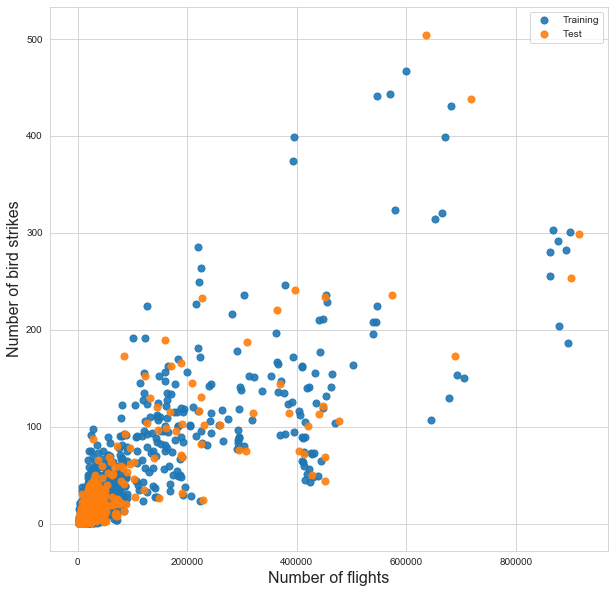

In [9]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(airport_strikes_train['NFLIGHTS'], airport_strikes_train['NSTRIKES'],alpha=.9,s=50,label='Training')
ax.scatter(airport_strikes_test['NFLIGHTS'], airport_strikes_test['NSTRIKES'],alpha=.9,s=50,label='Test')

plt.xlabel("Number of flights",fontsize = 16)
plt.ylabel("Number of bird strikes",fontsize = 16)

plt.legend()

plt.show()

In [10]:
airport_strikes_train[['NFLIGHTS','NSTRIKES']].corr()

,NFLIGHTS,NSTRIKES
NFLIGHTS,1.000000,0.830271
NSTRIKES,0.830271,1.000000


In [11]:
# Import Linear Regression from sklearn
from sklearn.linear_model import LinearRegression

In [12]:
# Make a model object
slr = LinearRegression(copy_X = True)

# Fit the model
slr.fit(airport_strikes_train['NFLIGHTS'].values.reshape(-1,1), airport_strikes_train['NSTRIKES'].values.ravel())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [13]:
# Coefficients
print("beta_1_hat is", slr.coef_[0])
print("beta_0_hat is", slr.intercept_)

beta_1_hat is 0.00036797044464126826
beta_0_hat is 7.219807684600809


In [14]:
# Interpretation of the best linear estimate of beta_1
print("A 50000 flights increase gives an estimated",
         np.round(slr.coef_[0]*50000,1),
          "additional bird strikes per year.")

A 50000 flights increase gives an estimated 18.4 additional bird strikes per year.


In [15]:
# Prediction
min_nf = 0
max_nf = airport_strikes_train['NFLIGHTS'].max()
padding = 120000
x = np.linspace(min_nf,max_nf + padding,100)

airport_strikes_predict = slr.predict(x.reshape(-1,1))

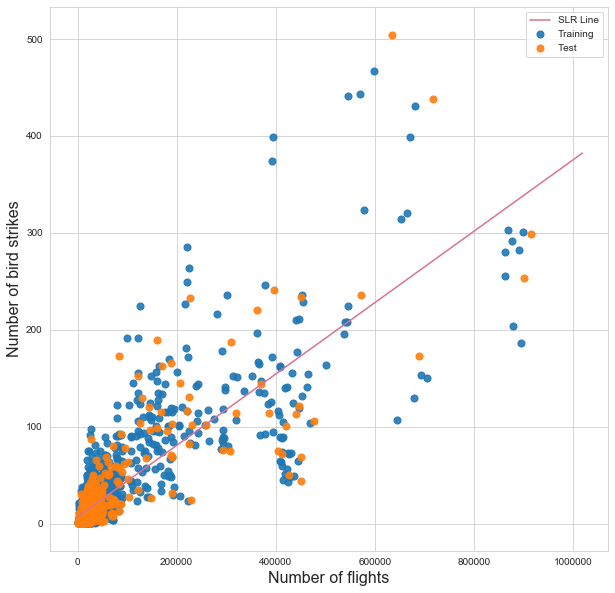

In [16]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(airport_strikes_train['NFLIGHTS'], airport_strikes_train['NSTRIKES'],alpha=.9,s=50,label='Training')
ax.scatter(airport_strikes_test['NFLIGHTS'], airport_strikes_test['NSTRIKES'],alpha=.9,s=50,label='Test')
ax.plot(x,airport_strikes_predict,c='palevioletred',label='SLR Line')

plt.xlabel("Number of flights",fontsize = 16)
plt.ylabel("Number of bird strikes",fontsize = 16)

plt.legend()

plt.show()

In [17]:
def rmse(y,y_pred,r):
    return np.round(np.sqrt(np.sum((y-y_pred)**2)/len(y)),r)

In [18]:
y_train = airport_strikes_train['NSTRIKES'].values
y_train_pred = slr.predict(airport_strikes_train['NFLIGHTS'].values.reshape(-1,1))

print("The training RMSE is",rmse(y_train,y_train_pred,2))

The training RMSE is 29.16


In [19]:
y_test = airport_strikes_test['NSTRIKES'].values
y_test_pred = slr.predict(airport_strikes_test['NFLIGHTS'].values.reshape(-1,1))

print("The testing RMSE is",rmse(y_test,y_test_pred,2))

The testing RMSE is 31.61


In [20]:
airport_strikes_nonzero.loc[airport_strikes_nonzero['AIRPORT_ID'] == 'KCLT']

,AIRPORT_ID,NFLIGHTS,YEAR,NSTRIKES,STATE,REGION
79,KCLT,538492,2015,196,NC,ASO
539,KCLT,539375,2016,208,NC,ASO
999,KCLT,546357,2017,225,NC,ASO
1459,KCLT,543674,2018,208,NC,ASO
1919,KCLT,572909,2019,236,NC,ASO


In [21]:
# Number of flights and birdstrikes at Charlotte/Douglas Intl in 2019
CLT_NFLIGHTS_2019 = airport_strikes_nonzero.loc[airport_strikes_nonzero['AIRPORT_ID'] == 'KCLT']['NFLIGHTS'][1919]
CLT_NSTRIKES_2019 = airport_strikes_nonzero.loc[airport_strikes_nonzero['AIRPORT_ID'] == 'KCLT']['NSTRIKES'][1919]

In [22]:
# Predicted number of flights (FAA forecast) and birdstrikes at Charlotte/Douglas Intl in 2045
CLT_NFLIGHTS_2045_PREDICT = np.array([937000])
CLT_NSTRIKES_2045_PREDICT = np.round(slr.predict(CLT_NFLIGHTS_2045_PREDICT.reshape(-1,1)),0)

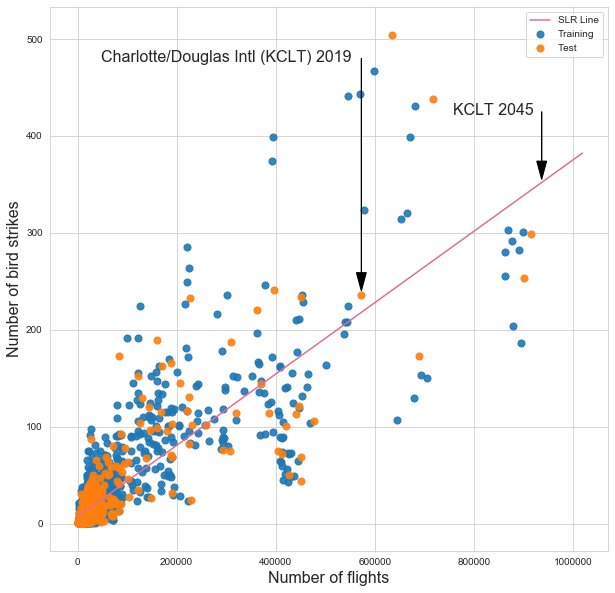

In [23]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(airport_strikes_train['NFLIGHTS'], airport_strikes_train['NSTRIKES'],alpha=.9,s=50,label='Training')
ax.scatter(airport_strikes_test['NFLIGHTS'], airport_strikes_test['NSTRIKES'],alpha=.9,s=50,label='Test')
#ax.scatter(airport_strikes_nonzero.loc[airport_strikes_nonzero['AIRPORT_ID']=='KCLT', 'NFLIGHTS'], airport_strikes_nonzero.loc[airport_strikes_nonzero['AIRPORT_ID']=='KCLT', 'NSTRIKES'],alpha=.9,s=100,label='Airport')
ax.plot(x,airport_strikes_predict,c='palevioletred',label='SLR Line')

ax.arrow(CLT_NFLIGHTS_2019, 480, 0, -221, head_width=20000, head_length=19, width=50, color="black")
ax.text(CLT_NFLIGHTS_2019-525000, CLT_NSTRIKES_2019 + 240, "Charlotte/Douglas Intl (KCLT) 2019", fontsize=16)

ax.arrow(CLT_NFLIGHTS_2045_PREDICT[0], 425, 0, -51, head_width=20000, head_length=19, width=50, color="black")
ax.text(CLT_NFLIGHTS_2045_PREDICT[0]-180000, CLT_NSTRIKES_2045_PREDICT[0] + 70,
        "KCLT 2045", fontsize=16)

plt.xlabel("Number of flights",fontsize = 16)
plt.ylabel("Number of bird strikes",fontsize = 16)

plt.legend()

plt.show()

460 US airports were analyzed

The training RMSE is 29.16; The testing RMSE is 31.61

A 50000 flights increase gives an estimated 18 additional bird strikes per year.

Prediction for KCLT in 2045 (used FAA forecast for the number of flights)
